In [1]:
import helper_funcs as hlp

import pickle
import numpy as np
from time import time
import matplotlib.pyplot as plt  
from sklearn.svm import SVC
from pytket.extensions.qiskit import AerBackend

In [2]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 2**13,
}

train_labels, train_data = hlp.read_data('mc_train_data.txt')
test_labels, test_data = hlp.read_data('mc_test_data.txt')

embedding = hlp.load_weights('trained_embeddings_new.pkl')
vocab = embedding['vocab']
vals = embedding['vals']

In [3]:
test_circs = hlp.build_circuits(test_data)
test_pred_fn = hlp.make_pred_fn(test_circs, vocab, backend_config=backend_config)
test_cost_fn, _, test_accs = hlp.make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(vals)
print(f'Test accuracy: {test_accs[-1]}')

Test accuracy: 0.9


## Kernelize

In [10]:
kernel = hlp.make_kernel_fn(vocab, vals, backend_config={},
                           get_sim_fn=hlp.get_transition_amp_sim_fn)
kernel(train_data[0], train_data[0])

Took 0.619 s to prep circs
Took 0.055 s to build matrix


array([[0.13262865]])

In [12]:
gram_train, gram_test = hlp.build_gram_matrices(
    train_data, test_data, vocab, vals, backend_config={}, get_sim_fn=hlp.get_transition_amp_sim_fn
)

Building circuits...


Took 12.384 s 
Building training Gram matrix...
Took 86.94 s 
Building testing Gram matrix...
Took 74.513 s 


In [ ]:
save_name = ''
if save_name:
    np.save(f'{save_name}_test.npy', gram_test)
    np.save(f'{save_name}_train.npy', gram_train)

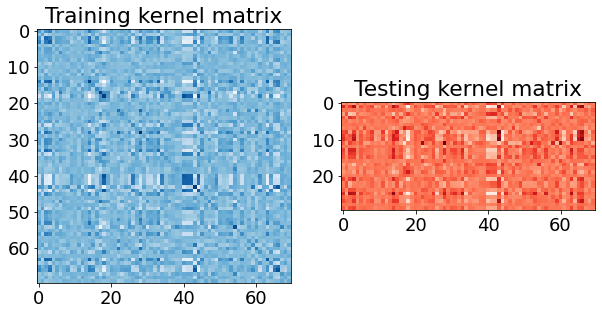

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(gram_train), interpolation="nearest", origin="upper", cmap="Blues")
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(gram_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

# plt.savefig(f'kernel_mats-qasm.pdf', dpi=1200, bbox_inches="tight")
plt.show()

In [14]:
svc = SVC(kernel="precomputed")

ts = time()
svc.fit(gram_train, train_labels[:, 0])
hlp.timestamp(time(), ts, 'to fit SVC')

ts = time()
score = svc.score(gram_test, test_labels[:, 0])
hlp.timestamp(time(), ts, 'to score SVC')

print(f"Precomputed kernel classification test score: {score}")

Took 2.029 s to fit SVC
Took 0.052 s to score SVC
Precomputed kernel classification test score: 0.5


## Grouping

In [35]:
def sort_data(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    is_class_0 = y[:, 0] == 0
    sorted_x = np.concatenate([x[is_class_0], x[~is_class_0]])
    sorted_y = np.concatenate([y[is_class_0], y[~is_class_0]])
    return sorted_x, sorted_y

In [3]:
train_labels, train_data = hlp.read_data('mc_train_data.txt')
test_labels, test_data = hlp.read_data('mc_test_data.txt')

train_data, train_labels = hlp.sort_data(train_data, train_labels)
test_data, test_labels = hlp.sort_data(test_data, test_labels)

Building circuits...


Took 7.757 s 
Building training Gram matrix...
Took 56.951 s 
Building testing Gram matrix...
Took 46.417 s 


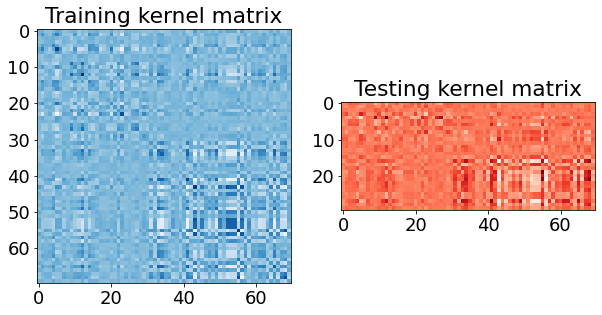

In [5]:
gram_train, gram_test = hlp.build_gram_matrices(
    train_data, test_data, vocab, vals, backend_config={}, get_sim_fn=hlp.get_transition_amp_sim_fn
)

hlp.display_grams(gram_train, gram_test)

In [6]:
svc = SVC(kernel="precomputed")

ts = time()
svc.fit(gram_train, train_labels[:, 0])
hlp.timestamp(time(), ts, 'to fit SVC')

ts = time()
score = svc.score(gram_test, test_labels[:, 0])
hlp.timestamp(time(), ts, 'to score SVC')

print(f"Precomputed kernel classification test score: {score}")

Took 0.002 s to fit SVC
Took 0.001 s to score SVC
Precomputed kernel classification test score: 0.5


Building circuits...


Took 7.555 s 
Building training Gram matrix...
Took 382.256 s 
Building testing Gram matrix...
Took 267.795 s 


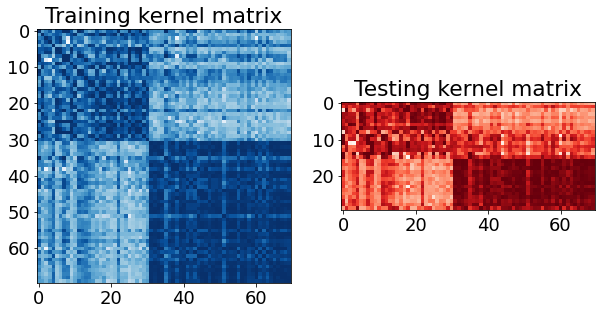

In [8]:
gram_train, gram_test = hlp.build_gram_matrices(
    train_data, test_data, vocab, vals, backend_config=backend_config, get_sim_fn=hlp.get_swap_test_fn
)

hlp.display_grams(gram_train, gram_test)